#### Optimization with PuLP
>The purpose of this notebook is to explore using optimization models for prescriptive analytics. I am going to solve the classic "diet problem" which finds the cheapest diet possible while satisfying maximimum and minimum daily nutrition constraints.
>
>I am going to add the following constraints to the model to get practice creating more complex models once the base model is created:
a.	If a food is selected, then a minimum of 1/10 serving must be chosen. (Hint: now you will need two variables for each food i: whether it is chosen, and how much is part of the diet. You’ll also need to write a constraint to link them.)
b.	Many people dislike celery and frozen broccoli. So at most one, but not both, can be selected.
c.	To get day-to-day variety in protein, at least 3 kinds of meat/poultry/fish/eggs must be selected.
>
>Lastly, I am going to solve the model with a larger dataset file diet_large.xls and change the optimization to be a low-cholesterol diet model (rather than minimizing cost, the goal is to minimize cholesterol intake).

The steps I plan to take to solve this problem are:
1. Load and explore the dataset
2. Create the PuLP optimization model for the base problem without the extra constraints
3. Create the PuLP optimization model for the base problem with the extra constraints
4. Create the PuLP optimization model for the full-sized problem

#### Step 1 - Load/Explore Dataset
To start, I am going to load the dataset and necessary libraries:

In [1]:
# Load libraries
import pulp # the optimization package
import pandas as pd # for storing the dataset
import seaborn as sns # for plotting
import matplotlib.pyplot as plt # for plotting
from scipy import stats # for getting r-squared values

In [2]:
# Load the dataset
dietData = pd.read_excel('diet.xls', index_col='Foods')

# Look at the dataset
dietData.tail()

,Price/ Serving,Serving Size,Calories,Cholesterol mg,Total_Fat g,Sodium mg,Carbohydrates g,Dietary_Fiber g,Protein g,Vit_A IU,Vit_C IU,Calcium mg,Iron mg
Foods,,,,,,,,,,,,,
"Crm Mshrm Soup,W/Mlk",0.65,1 C (8 Fl Oz),203.4,19.8,13.6,1076.3,15.0,0.5,6.1,153.8,2.2,178.6,0.6
"Beanbacn Soup,W/Watr",0.67,1 C (8 Fl Oz),172.0,2.5,5.9,951.3,22.8,8.6,7.9,888.0,1.5,81.0,2.0
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,Minimum daily intake,1500.0,30.0,20.0,800.0,130.0,125.0,60.0,1000.0,400.0,700.0,10.0
NaN,NaN,Maximum daily intake,2500.0,240.0,70.0,2000.0,450.0,250.0,100.0,10000.0,5000.0,1500.0,40.0


One of the things I noticed looking at the excel sheet was that the last few rows are actually listing constraints on the various nutritional values. I don't want those in my dataset so I am going to turn them into seperate lists and drop those rows.

In [3]:
# Get minimum and maximum values
minimums = dietData[65:66].values
minimums = minimums[0][2:].tolist()
maximums = dietData[66:67].values
maximums = maximums[0][2:].tolist()
print(f'List of minimum values for each nutrient: {minimums}')
print(f'List of maximum values for each nutrient: {maximums}')

# Delete rows 64-66
dietData = dietData.iloc[:64,]
dietData.tail()

List of minimum values for each nutrient: [1500.0, 30.0, 20.0, 800.0, 130.0, 125.0, 60.0, 1000.0, 400.0, 700.0, 10.0]
List of maximum values for each nutrient: [2500.0, 240.0, 70.0, 2000.0, 450.0, 250.0, 100.0, 10000.0, 5000.0, 1500.0, 40.0]


,Price/ Serving,Serving Size,Calories,Cholesterol mg,Total_Fat g,Sodium mg,Carbohydrates g,Dietary_Fiber g,Protein g,Vit_A IU,Vit_C IU,Calcium mg,Iron mg
Foods,,,,,,,,,,,,,
Neweng Clamchwd,0.75,1 C (8 Fl Oz),175.7,10.0,5.0,1864.9,21.8,1.5,10.9,20.1,4.8,82.8,2.8
Tomato Soup,0.39,1 C (8 Fl Oz),170.7,0.0,3.8,1744.4,33.2,1.0,4.1,1393.0,133.0,27.6,3.5
"New E Clamchwd,W/Mlk",0.99,1 C (8 Fl Oz),163.7,22.3,6.6,992.0,16.6,1.5,9.5,163.7,3.5,186.0,1.5
"Crm Mshrm Soup,W/Mlk",0.65,1 C (8 Fl Oz),203.4,19.8,13.6,1076.3,15.0,0.5,6.1,153.8,2.2,178.6,0.6
"Beanbacn Soup,W/Watr",0.67,1 C (8 Fl Oz),172.0,2.5,5.9,951.3,22.8,8.6,7.9,888.0,1.5,81.0,2.0


Now that is cleaned up, I want to get some basic information about the dataset.

In [4]:
# Get name, datatype, and Null count information
dietData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, Frozen Broccoli to Beanbacn Soup,W/Watr
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price/ Serving   64 non-null     float64
 1   Serving Size     64 non-null     object 
 2   Calories         64 non-null     float64
 3   Cholesterol mg   64 non-null     float64
 4   Total_Fat g      64 non-null     float64
 5   Sodium mg        64 non-null     float64
 6   Carbohydrates g  64 non-null     float64
 7   Dietary_Fiber g  64 non-null     float64
 8   Protein g        64 non-null     float64
 9   Vit_A IU         64 non-null     float64
 10  Vit_C IU         64 non-null     float64
 11  Calcium mg       64 non-null     float64
 12  Iron mg          64 non-null     float64
dtypes: float64(12), object(1)
memory usage: 7.0+ KB


In [5]:
# Get basic statistics
dietData.describe()

,Price/ Serving,Calories,Cholesterol mg,Total_Fat g,Sodium mg,Carbohydrates g,Dietary_Fiber g,Protein g,Vit_A IU,Vit_C IU,Calcium mg,Iron mg
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,0.327188,134.384375,18.071875,5.185937,332.126562,16.437500,1.503125,6.071875,777.132812,11.498437,50.296875,1.587500
std,0.254536,120.790475,42.114117,9.684530,491.718977,18.257971,2.216817,6.706771,2173.534758,28.957448,75.257796,2.477998
min,0.020000,2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.900000,0.000000
25%,0.145000,73.400000,0.000000,0.500000,16.175000,4.625000,0.000000,1.975000,11.750000,0.000000,6.775000,0.300000
50%,0.270000,109.400000,0.000000,2.650000,137.250000,15.050000,0.700000,4.050000,95.450000,1.550000,20.400000,0.700000
75%,0.460000,159.500000,17.625000,6.700000,335.100000,22.150000,1.850000,8.025000,499.900000,7.525000,51.650000,2.025000
max,0.990000,710.800000,211.500000,72.200000,1915.100000,128.200000,11.600000,42.200000,15471.000000,160.200000,302.300000,16.800000


In [6]:
# Look at the unique values in the serving size column
dietData['Serving Size'].unique()

array(['10 Oz Pkg', '1/2 Cup Shredded', '1 Stalk', '1/2 Cup', '1 Leaf',
       '1 Pepper', '1/4 block', '1 lb chicken', '1 1/2 Cup',
       '1 Tomato, 2-3/5 In', '1 Fruit,3/Lb,Wo/Rf', '1 Fruit,Wo/Skn&Seeds',
       '10 Fruits,Wo/Rf', '1 Med Frt,Wo/Skin', '1 Frt,2-5/8 Diam', '1 Oz',
       '1 Sl', '1 Cookie', '1 Pat', '1 C', 'Lrg Egg', '1 Egg',
       '1 Frankfurter', '1 Sl,6-1/4x4x1/16 In', '1 Sl,6x3-3/4x1/16 In',
       '1.3 Oz', '1 Slice', '1 Small Taco', '1 Burger', '1 Hotdog',
       '2 Tbsp', '4 Oz', '2 Sardines', '3 Oz', '1 C (8 Fl Oz)'],
      dtype=object)

Next I am going to output a histogram for each of the values and look at how each of the values correlate with each other.

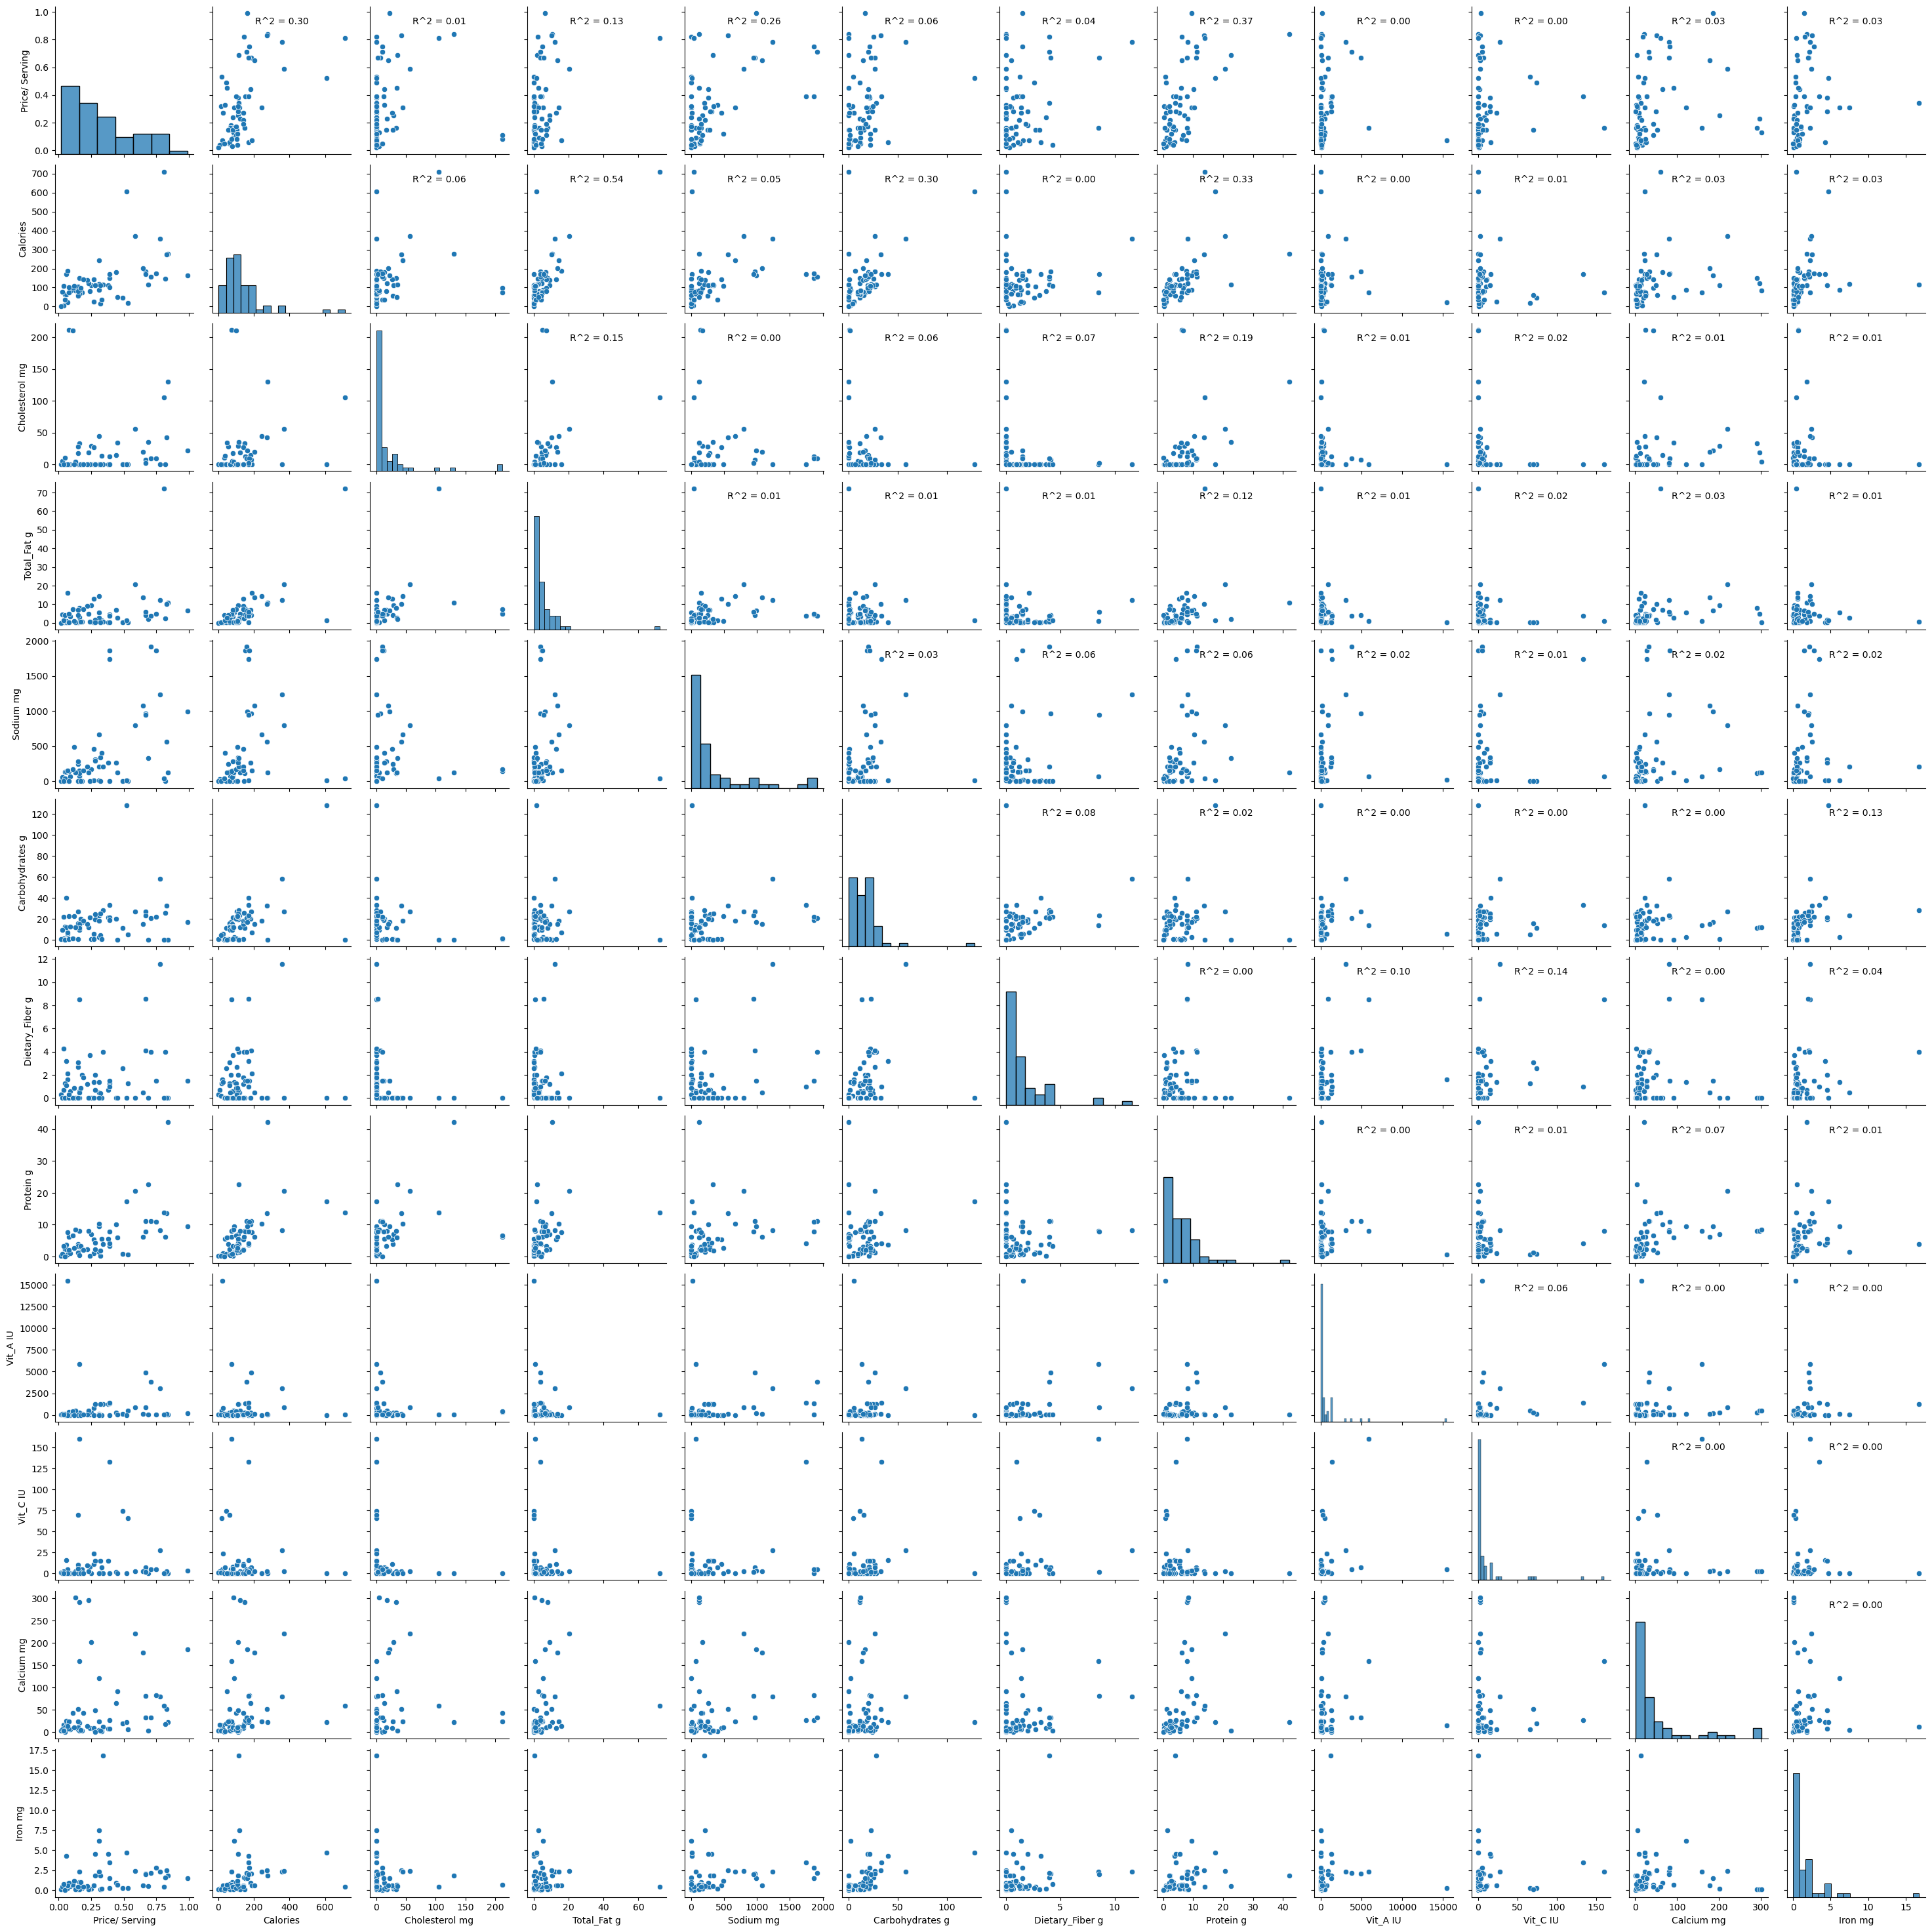

In [7]:
# Exclude object dtype columns
numerical_columns = dietData.select_dtypes(include=['float64', 'int64']).columns

# Create a pairplot
pair_plot = sns.pairplot(dietData[numerical_columns])

# Function to calculate R-squared value
def calculate_r_squared(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value ** 2

# Calculate and annotate R-squared values
for i, j in zip(*plt.np.tril_indices_from(pair_plot.axes, -1)):
    pair_plot.axes[j, i].annotate("R^2 = {:.2f}".format(
        calculate_r_squared(dietData[numerical_columns].iloc[:, i], dietData[numerical_columns].iloc[:, j])),
                                  (0.5, 0.9), xycoords='axes fraction',
                                  ha='center', va='center')

plt.show()

Looking at the data, their are 64 different food types with 12 nutrional facts for each of the food items. The dataset also includes the name of the food and the serving size which are both string objects. There aren't any missing values in the data and looking at the histograms and sd, max, and min values there are several outliers (calories, iron, carbs, etc.) but upon investigation they all make sense. It does appear that their is strong correlation between several nutritional parameters but they all make sense and aren't part of this analysis. Now that I understand the data better I'm ready to sart the optimization problem.

#### Step 2 - Create Optimization Model w/o Additional Constraints
Next, I am going to setup and solve the optimization model for the base case. I am using the PuLP package and found this example helpful in building and solving the model: https://coin-or.github.io/pulp/CaseStudies/a_blending_problem.html and used the documentation found here: https://coin-or.github.io/pulp/technical/pulp.html#pulp.LpVariable

In [8]:
# Create base model
dietBase = pulp.LpProblem('DietProblem', pulp.LpMinimize)

# Add a variable for each type of food
foods = pulp.LpVariable.dicts("food", dietData.index, 0)

# Add a variable for if the food was selected
foodsSelected = pulp.LpVariable.dicts("foodSelected", dietData.index, 0, 1, pulp.LpBinary)

Now that the model is created and variables added I'm ready to create the objective function

In [9]:
dietBase += pulp.lpSum([foods[food] * dietData.loc[food, 'Price/ Serving'] for food in dietData.index])

Now I'm ready to add the constraints to the model

In [10]:
# Constraint for nutrients
# Start by creating a dictionary of all the nutrient values for each food
food_dict = {}
for food in dietData.index:
    food_dict[food] = [float(dietData.loc[food, nutrient]) for nutrient in dietData.columns[2:]]

for i in range(len(dietData.columns[2:])):
    dietBase += pulp.lpSum([food_dict[food][i] * foods[food] for food in dietData.index]) >= minimums[i]
    dietBase += pulp.lpSum([food_dict[food][i] * foods[food] for food in dietData.index]) <= maximums[i]

I'm going to print out the objective function to make sure it was created correctly.

In [11]:
dietBase.objective

0.23*food_2%_Lowfat_Milk + 0.16*food_3.3%_Fat,Whole_Milk + 0.24*food_Apple,Raw,W_Skin + 0.16*food_Apple_Pie + 0.16*food_Bagels + 0.15*food_Banana + 0.67*food_Beanbacn_Soup,W_Watr + 0.15*food_Bologna,Turkey + 0.05*food_Butter,Regular + 0.31*food_Cap'N_Crunch + 0.07*food_Carrots,Raw + 0.04*food_Celery,_Raw + 0.25*food_Cheddar_Cheese + 0.28*food_Cheerios + 0.39*food_Chicknoodl_Soup + 0.03*food_Chocolate_Chip_Cookies + 0.28*food_Corn_Flks,_Kellogg'S + 0.39*food_Couscous + 0.65*food_Crm_Mshrm_Soup,W_Mlk + 0.27*food_Frankfurter,_Beef + 0.16*food_Frozen_Broccoli + 0.18*food_Frozen_Corn + 0.32*food_Grapes + 0.33*food_Ham,Sliced,Extralean + 0.83*food_Hamburger_W_Toppings + 0.31*food_Hotdog,_Plain + 0.15*food_Kielbasa,Prk + 0.49*food_Kiwifruit,Raw,Fresh + 0.02*food_Lettuce,Iceberg,Raw + 0.17*food_Macaroni,Ckd + 0.52*food_Malt_O_Meal,Choc + 0.99*food_New_E_Clamchwd,W_Mlk + 0.75*food_Neweng_Clamchwd + 0.82*food_Oatmeal + 0.09*food_Oatmeal_Cookies + 0.15*food_Oranges + 0.07*food_Peanut_Butter + 0.5

In [12]:
dietBase.solve()

1

In [13]:
for variable in dietBase.variables():
    if variable.varValue > 0:
        print(str(variable.varValue)+" units of " + str(variable).replace("food_",""))

52.64371 units of Celery,_Raw
0.25960653 units of Frozen_Broccoli
63.988506 units of Lettuce,Iceberg,Raw
2.2929389 units of Oranges
0.14184397 units of Poached_Eggs
13.869322 units of Popcorn,Air_Popped


The results above match the expected results as denoted in the original problem statement which is good! Now I am going to add the additional contraints and see how it effects the model.

#### Step 3 - Create Optimization Model with Additional Constraints
I'm going to use the same base model and just add the additional contraints for the minimum amounts of servings, celery vs broccoli, and having 3 protiens.

In [16]:
# Constraint a - If a food is selected, then a minimum of 1/10 of a serving must be chosen
for food in dietData.index:
    dietBase += foods[food] >= 0.1 * foodsSelected[food]
    dietBase += foodsSelected[food] >= foods[food] * 0.0000001 # This just insures that the foodSelected variable is 1 (binary so can only be 1 or 0) if the food is selected

# Constraint b - Only celery or frozen broccoli but not both
dietBase += foodsSelected['Frozen Broccoli'] + foodsSelected['Celery, Raw'] <= 1

# Constraint c - At least three kinds of protein
dietBase += foodsSelected['Roasted Chicken'] + foodsSelected['Poached Eggs'] + foodsSelected['Scrambled Eggs'] \
            + foodsSelected['Bologna,Turkey'] + foodsSelected['Frankfurter, Beef'] + foodsSelected['Ham,Sliced,Extralean'] \
            + foodsSelected['Kielbasa,Prk'] + foodsSelected['Pizza W/Pepperoni'] + foodsSelected['Taco'] \
            + foodsSelected['Hamburger W/Toppings'] + foodsSelected['Hotdog, Plain'] + foodsSelected['Pork'] \
            + foodsSelected['Sardines in Oil'] + foodsSelected['White Tuna in Water'] + foodsSelected['Chicknoodl Soup'] \
            + foodsSelected['Splt Pea&Hamsoup'] + foodsSelected['Vegetbeef Soup'] + foodsSelected['Neweng Clamchwd'] \
            + foodsSelected['New E Clamchwd,W/Mlk'] + foodsSelected['Beanbacn Soup,W/Watr'] >= 3

Now I'm ready to solve the problem and check the results!

In [17]:
dietBase.solve()
for variable in dietBase.variables():
    if variable.varValue > 0 and "foodSelected" not in variable.name:
        print(str(variable.varValue)+" units of " + str(variable).replace("food_",""))

42.399358 units of Celery,_Raw
0.1 units of Kielbasa,Prk
82.802586 units of Lettuce,Iceberg,Raw
3.0771841 units of Oranges
1.9429716 units of Peanut_Butter
0.1 units of Poached_Eggs
13.223294 units of Popcorn,Air_Popped
0.1 units of Scrambled_Eggs


The results above are similar to the original results but no longer has frozen broccoli and includes three proteins (poached eggs, scrambled eggs, and kielbasa pork) all at the minimum amount allowed for each category (0.1 units). This would be a rough diet...

#### Step 4 - Optimization model with full dataset
Next, I am going to create the final model using the full dataset. I'll load the new dataset, perform the same transformations as I did on the original, and create the new model. I have to reset the environment first so the PuLP model is a new one.

In [18]:
# Reset notebook so I can create a new model
%reset -f

# Reload libraries
import pulp # the optimization package
import pandas as pd # for storing the dataset
import seaborn as sns # for plotting
import matplotlib.pyplot as plt # for plotting
from scipy import stats # for getting r-squared values

In [19]:
# Load the dataset
dietDataFull = pd.read_excel('diet_large.xls', skiprows=1)

# Look at the dataset
dietDataFull.tail()

,Long_Desc,Protein,"Carbohydrate, by difference",Energy,Water,Energy.1,"Calcium, Ca","Iron, Fe","Magnesium, Mg","Phosphorus, P",...,Riboflavin,Niacin,Pantothenic acid,Vitamin B-6,"Folate, total",Vitamin B-12,Vitamin K (phylloquinone),Cholesterol,"Fatty acids, total trans","Fatty acids, total saturated"
7145,"Turtle, green, raw",19.8,0,89,78.5,372.0,118,1.4,20,180,...,0.15,1.1,NaN,0.12,15,1,0.1,50.0,NaN,0.127
7146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7147,NaN,56,130,2400,3700,2400.0,1000,8,270,700,...,1.3,16,5,1.3,400,2.4,120,NaN,NaN,NaN
7148,NaN,g/d,g/d,kcal,g,NaN,mg/d,mg/d,mg/d,mg/d,...,mg/d,mg/d,mg/d,mg/d,microg/d,microg/d,microg/d,NaN,NaN,NaN
7149,NaN,1000000,1000000,1000000,1000000,1000000.0,2500,45,400,4000,...,1000000,35,1000000,100,1000,1000000,1000000,NaN,NaN,NaN


Just like in the previous model their are values included for max/min ranges for each nutrient in the last few lines. I am going to extract those and then delete them from the dataset.

In [20]:
# Get minimum and maximum values
full_min = dietDataFull[7147:7148].values
full_min = full_min[0][1:-3].tolist()
full_max = dietDataFull[7149:7151].values
full_max = full_max[0][1:-3].tolist()
print(f'List of minimum values for each nutrient: {full_min}')
print(f'List of maximum values for each nutrient: {full_max}')

# Delete rows with max/min values
dietDataFull = dietDataFull.iloc[:7146,]

List of minimum values for each nutrient: [56, 130, 2400, 3700, 2400.0, 1000, 8, 270, 700, 4700, 1500, 11, 0.9, 2.3, 55, 900, 15, 200, 90, 0.0012, 1.3, 16, 5, 1.3, 400, 2.4, 120]
List of maximum values for each nutrient: [1000000, 1000000, 1000000, 1000000, 1000000.0, 2500, 45, 400, 4000, 1000000, 2300, 40, 10, 11, 400, 3000, 1000, 2000, 2000, 1000000, 1000000, 35, 1000000, 100, 1000, 1000000, 1000000]


It's worth noting that the last three nutrients don't have max/min values. The table has nan values that need to be replaced with 0 and I was having issues using the index for the food name in this model so I am also going to create a list of the foods, and dictionaries for the cholesterol and nutrients. I'm not going to include the last three nutrients in the nutrients dictionaries since they won't have max/min values to check against.

In [22]:
# Replace nan values
dietDataFull = dietDataFull.fillna(0).infer_objects(copy=False)

# Create list of foods
foodList = dietDataFull['Long_Desc'].tolist()
print(foodList[:5])

# Cholesterol dictionary
cholDict = dietDataFull.set_index(dietDataFull.columns[0])[dietDataFull.columns[28]].to_dict()
print(cholDict['Butter, salted'])

# Nutrients dictionary
nutr_dict = {}
for i in range(len(foodList)):
    nutr_dict[foodList[i]] = [float(dietDataFull.loc[i, nutrient]) for nutrient in dietDataFull.columns[1:-3]]

print(nutr_dict['Butter, salted'])

['Butter, salted', 'Butter, whipped, with salt', 'Butter oil, anhydrous', 'Cheese, blue', 'Cheese, brick']
215.0
[0.85, 0.06, 717.0, 15.87, 3000.0, 24.0, 0.02, 2.0, 24.0, 24.0, 576.0, 0.09, 0.0, 0.0, 1.0, 684.0, 2.32, 56.0, 0.0, 0.005, 0.034, 0.042, 0.11, 0.003, 3.0, 0.17, 7.0]


Now I'm ready to create my model

In [23]:
# Create base model
dietFull = pulp.LpProblem('FullDietProblem', pulp.LpMinimize)

# Add a variable for each type of food
foods = pulp.LpVariable.dicts("food", foodList, 0)

# Add a variable for if the food was selected
foodsSelected = pulp.LpVariable.dicts("foodSelected", foodList, 0, 1, pulp.LpBinary)

Create the objective function

In [24]:
dietFull += pulp.lpSum([foods[food] * cholDict[food] for food in foodList])

Add constraints for each nutrient

In [25]:
for i in range(len(dietDataFull.columns[1:-3])):
    dietFull += pulp.lpSum([nutr_dict[food][i] * foods[food] for food in foodList]) >= full_min[i]
    dietFull += pulp.lpSum([nutr_dict[food][i] * foods[food] for food in foodList]) <= full_max[i]

Now I'm ready to solve the model and review the results!

In [26]:
dietFull.solve()
for variable in dietFull.variables():
    if variable.varValue > 0 and "foodSelected" not in variable.name:
        print(str(variable.varValue)+" units of " + str(variable).replace("food_",""))

0.059863415 units of Beans,_adzuki,_mature_seeds,_raw
0.069514608 units of Broccoli_raab,_raw
0.42866218 units of Cocoa_mix,_no_sugar_added,_powder
0.14694398 units of Egg,_white,_dried,_flakes,_glucose_reduced
0.73805891 units of Infant_formula,_MEAD_JOHNSON,_ENFAMIL,_NUTRAMIGEN,_with_iron,_p
0.4258564 units of Infant_formula,_NESTLE,_GOOD_START_ESSENTIALS__SOY,__with_iron,
0.050114149 units of Infant_formula,_ROSS,_ISOMIL,_with_iron,_powder,_not_reconstitu
0.15033656 units of Margarine_like_spread,_approximately_60%_fat,_tub,_soybean_(hyd
0.25918767 units of Mung_beans,_mature_seeds,_raw
0.18052856 units of Nuts,_mixed_nuts,_dry_roasted,_with_peanuts,_with_salt_added
1.184482 units of Oil,_vegetable,_sunflower,_linoleic,_(hydrogenated)
0.10375187 units of Seeds,_sunflower_seed_kernels,_dry_roasted,_with_salt_added
0.031866196 units of Snacks,_potato_chips,_fat_free,_made_with_olestra
0.070710308 units of Spices,_paprika
0.55106575 units of Tomatoes,_sun_dried
9999.6864 units of Water

The results are certainly interesting! All of the items have 0 cholesterol which isn't suprising since that is what we are trying to minimize. It is calling for 9,999 bottles of water which essentially makes the water nutrient just below the maximum level. It decided to hit the maximum value for each of the nutrient categories which is why additional constraints would be good. Drinking 9,999 bottles of water a day would cause some issues...